# transfer learning = pre-trained network

In [ ]:
# database ImageNet: animals, and everyday objects, 1.4 milion image, 1000 class, interduced in 2014 
# network: VGG16 trained on ImageNet
# more recent networks: VGG16: VGG19, ResNet50, Inception V3, Xception, MobileNet

In [1]:
import os, shutil


original_dataset_dir='./dogs-vs-cats/train' 
base_dir='./dogs-vs-cats/mine practice'


# making directory:
train_dir=os.path.join(base_dir,'train') 
validation_dir=os.path.join(base_dir,'validation') 
test_dir=os.path.join(base_dir,'test') 


train_cats_dir=os.path.join(train_dir,'cats') 
train_dogs_dir=os.path.join(train_dir,'dogs') 

validation_cats_dir=os.path.join(validation_dir,'cats') 
validation_dogs_dir=os.path.join(validation_dir,'dogs') 

test_cats_dir=os.path.join(test_dir,'cats') 
test_dogs_dir=os.path.join(test_dir,'dogs') 

In [2]:
from keras.applications.vgg16 import VGG16

# conv_base an obj from VGG16:
conv_base = VGG16(weights='imagenet' , 
                  include_top=False, 
                  input_shape=(150,150,3)) 

58889256/58889256 [==============================] - 242s 4us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# method 1: fast feature extration

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen=ImageDataGenerator(rescale=1./255) 
batch_size=20


def extract_features(directory, sample_count): 
    features=np.zeros(shape=(sample_count,4,4,512)) 
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(directory,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          shuffle=False) 
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch) 
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1 
        if i*batch_size >= sample_count: 
            break
        return features, labels


train_features, train_labels=extract_features(train_dir, 2000)
validation_features, validation_labels=extract_features(validation_dir, 1000)
test_features, test_labels=extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:

train_features= np.reshape(train_features, (2000, 4*4*512)) # reshape (2000,4,4,512)-->(2000, 4*4*512)
validation_features= np.reshape(validation_features, (1000, 4*4*512))
test_features= np.reshape(test_features, (1000, 4*4*512))

In [17]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model= models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))


model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

model_history= model.fit(train_features, train_labels,
                        epochs=30,
                        batch_size=20,
                        validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 9s 71ms/step - loss: 0.6892 - acc: 0.9970 - val_loss: 0.6746 - val_acc: 1.0000
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 0.6758 - acc: 1.0000 - val_loss: 0.6639 - val_acc: 1.0000
Epoch 3/30
100/100 [==============================] - 6s 62ms/step - loss: 0.6662 - acc: 1.0000 - val_loss: 0.6548 - val_acc: 1.0000
Epoch 4/30
100/100 [==============================] - 6s 62ms/step - loss: 0.6567 - acc: 1.0000 - val_loss: 0.6454 - val_acc: 1.0000
Epoch 5/30
100/100 [==============================] - 6s 65ms/step - loss: 0.6470 - acc: 1.0000 - val_loss: 0.6356 - val_acc: 1.0000
Epoch 6/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6370 - acc: 1.0000 - val_loss: 0.6256 - val_acc: 1.0000
Epoch 7/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6269 - acc: 1.0000 - val_loss: 0.6153 - val_acc: 1.0000
Epoch 8/30
100/100 [==============================] - 6s 65ms/step - 

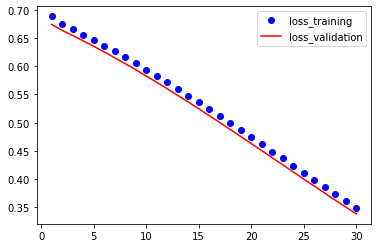

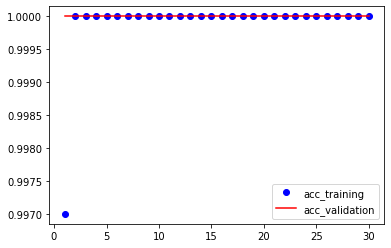

In [22]:
#overfit checking

history_dict=model_history.history

import matplotlib.pyplot as plt
loss_values_train=history_dict['loss'] #  train loss 
loss_values_val=history_dict['val_loss'] #  validation loss 

acc_train=history_dict['acc'] 
acc_val=history_dict['val_acc'] 

epoches=range(1, len(loss_values_train)+1)

plt.figure()
plt.plot(epoches,loss_values_train, 'bo',label='loss_training')
plt.plot(epoches,loss_values_val,'r', label='loss_validation')
plt.legend()
plt.show()


plt.figure()
plt.plot(epoches,acc_train, 'bo',label='acc_training')
plt.plot(epoches,acc_val,'r', label='acc_validation')
plt.legend()
plt.show()

# method 2: add dense layers at the end of pretrained model

In [26]:

model=models.Sequential()
model.add(conv_base)
conv_base.trainable=False 
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

len(model.trainable_weights)

4

In [ ]:
# data augmantation:
train_datagen=ImageDataGenerator(rescale=1./255,
                          rotation_range=40, # [-40 40] 
                          width_shift_range=0.2, # [-0.2 0.2] 
                          height_shift_range=0.2,
                          shear_range=0.2, 
                          zoom_range=0.2, # [1-0.2  1+0.2] 
                          horizontal_flip=True, # flip 
                          fill_mode='nearest')


train_generator= train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(150,150), # resize all image to 150*150
                                                  batch_size=20, 
                                                  class_mode='binary')

validation_datagen=ImageDataGenerator(rescale=1./255)

validation_generator= validation_datagen.flow_from_directory(validation_dir, 
                                                   target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary') #shuffel=True (defult)

In [ ]:
# training
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                 loss='binary_crossentropy', 
                 metrics=['acc'])  # accuracy

model_history=model.fit(train_generator,
                        steps_per_epoch=100, #how many batches in each epoch
                        epochs=30,
                        validation_data=validation_generator, 
                        validation_steps=50) #how many batches for validation 

# method 3: fine tuning

In [ ]:
# this is the continuation of method 2

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# unfreeze last layer, block5_conv1
set_trainable= False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.tranable=False

In [ ]:
# training

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5), # learning_rate
                 loss='binary_crossentropy', # binary clasification 
                 metrics=['acc'])  # accuracy

model_history=model.fit(train_generator,
                        steps_per_epoch=100, #how many batches in each epoch, 
                        epochs=100,
                        validation_data=validation_generator, 
                        validation_steps=50) #how many batches for validation, 

In [ ]:
# test
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator= test_datagen.flow_from_directory(test_dir, 
                                                 target_size=(150,150),
                                                 batch_size=20,
                                                 class_mode='binary') #shuffel=True (defult)

test_loss, test_acc=model.evaluate(test_generator, step=50) 
print(test_loss, test_acc)